In [1]:
!pip install -q -U keras_cv
!pip install -q -U tensorflow 

In [2]:
import tensorflow as tf 

from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


## Set up GPU Cluster
* Install Runhouse and latest SkyPilot version
* Set up LambdaLabs or BYO credentials
* Instantiate and launch cluster

In [ ]:
!pip install runhouse
!pip install git+https://github.com/skypilot-org/skypilot.git

In [4]:
import runhouse as rh

INFO | 2023-03-11 02:33:55,152 | No auth token provided, so not using RNS API to save and load configs


### Option 1: On Demand Cluster that spins up/down for you

In [ ]:
# To see instructions on how to set up cloud credentials. Skip if using your own cluster
!sky check

In [5]:
# For Lambda Labs
# First get your API key from https://cloud.lambdalabs.com/api-keys
# and create the file lambda_keys with the following line
# api_key = [YOUR API KEY]

!mkdir ~/.lambda_cloud/
!mv lambda_keys ~/.lambda_cloud/lambda_keys
!sky check

SkyPilot collects usage data to improve its services. `setup` and `run` commands are not collected to ensure privacy.
Usage logging can be disabled by setting the environment variable SKYPILOT_DISABLE_USAGE_COLLECTION=1.
Checking credentials to enable clouds for SkyPilot.
  AWS: disabled          
    Reason: AWS credentials are not set. Run the following commands:
      $ pip install boto3
      $ aws configure
    For more info: https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-quickstart.html
  Azure: disabled          
    Reason: ~/.azure/msal_token_cache.json does not exist. Run the following commands:
      $ az login
      $ az account set -s <subscription_id>
    For more info: https://docs.microsoft.com/en-us/cli/azure/get-started-with-azure-cli
  GCP: disabled          
    Reason: GCP tools are not installed or credentials are not set. Run the following commands:
      $ pip install google-api-python-client
      $ conda install -c conda-forge google-cloud-sdk 

In [7]:
# Launch on-demand Lambda cluster
gpu = rh.cluster(name='rh-a100', instance_type='A100:1', provider='lambda')
gpu.up_if_not()

# set amount of time (min) of inactivity to shut down cluster, or -1 to keep up indefinitely (Default: 30 min)
gpu.autostop_mins = -1

INFO | 2023-03-11 02:34:50,019 | Running command on rh-a100: mkdir -p ~/.rh; touch ~/.rh/cluster_config.yaml; echo '{"name": "~/rh-a100", "resource_type": "cluster", "resource_subtype": "OnDemandCluster", "instance_type": null, "num_instances": null, "provider": "cheapest", "autostop_mins": -1, "use_spot": false, "image_id": null, "region": null}' > ~/.rh/cluster_config.yaml


Output()

In [5]:
!sky status

Clusters
NAME     LAUNCHED  RESOURCES                                 STATUS  AUTOSTOP  COMMAND                       
rh-a100  1 hr ago  1x Lambda(gpu_1x_a100_sxm4, {'A100': 1})  UP      (down)    /usr/local/lib/python3.9/...  

Managed spot jobs
⠋ Checking spot jobs
No in progress jobs. (See: sky spot -h)


### Option 2: Bring-your-own cluster, by passing in IPs and SSH creds

In [ ]:
# Uncomment for bring-your-own cluster. This can be a cluster spun up by Lambda Labs
# gpu = rh.cluster(name='byo-lambda', ips=['<ip_address>'],
#                  ssh_creds={'ssh_user':'ubuntu', 'ssh_private_key': '~/.ssh/id_rsa'})

INFO | 2023-03-09 14:48:24,824 | Running command on byo-lambda: ray start --head
INFO | 2023-03-09 14:48:29,587 | Running command on byo-lambda: mkdir -p ~/.rh; touch ~/.rh/cluster_config.yaml; echo '{"name": "~/byo-lambda", "resource_type": "cluster", "resource_subtype": "Cluster", "ips": ["132.145.193.245"], "ssh_creds": {"ssh_user": "ubuntu", "ssh_private_key": "~/.ssh/id_rsa"}}' > ~/.rh/cluster_config.yaml


### Set up Tensorflow with GPU Support

Install Tensorflow, and check that it has GPU set up properly.

In [ ]:
command = "conda install -y -c conda-forge cudatoolkit=11.2.2 cudnn=8.1.0; \
           mkdir -p $CONDA_PREFIX/etc/conda/activate.d; \
           echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/' > $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh; \
           python3 -m pip install tensorflow"
gpu.run([command])
gpu.restart_grpc_server()  # restart server to use env variables set above

In [15]:
gpu.run(['python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices(\'GPU\'))"'])

INFO | 2023-03-11 02:08:29,557 | Running command on rh-a100: python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
2023-03-11 02:08:30.990499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 02:08:31.752645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/miniconda3/lib/:/home/ubuntu/miniconda3/lib/
2023-03-11 02:08:31.752720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

[(0,
  "2023-03-11 02:08:30.990499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA\nTo enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.\n2023-03-11 02:08:31.752645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/miniconda3/lib/:/home/ubuntu/miniconda3/lib/\n2023-03-11 02:08:31.752720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/miniconda3/lib/:/home/ubuntu/miniconda3/lib/\n

## Dreambooth Setup

### Download the instance and class images

In [16]:
tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/instance-images.tar.gz",
    untar=True
)
tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/class-images.tar.gz",
    untar=True
)

9093120/9093120 [==============================] - 0s 0us/step


'/root/.keras/datasets/class-images'

In [17]:
instance_images_root = '~/.keras/datasets/instance-images'
class_images_root = '~/.keras/datasets/class-images'

# sync images to the cluster using Runhouse
rh.folder(path=instance_images_root).to(system=gpu, path=instance_images_root)
rh.folder(path=class_images_root).to(system=gpu, path=class_images_root)

INFO | 2023-03-11 02:08:40,633 | Creating new file folder if it does not already exist in path: /root/.keras/datasets/instance-images
INFO | 2023-03-11 02:08:40,646 | Copying folder from file:///root/.keras/datasets/instance-images to: rh-a100, with path: ~/.keras/datasets/instance-images
INFO | 2023-03-11 02:08:40,649 | Creating new ssh folder if it does not already exist in path: .keras/datasets/instance-images
INFO | 2023-03-11 02:08:40,726 | Opening SSH connection to 193.122.153.217, port 22
INFO | 2023-03-11 02:08:40,786 | [conn=0] Connected to SSH server at 193.122.153.217, port 22
INFO | 2023-03-11 02:08:40,788 | [conn=0]   Local address: 172.28.0.12, port 35298
INFO | 2023-03-11 02:08:40,791 | [conn=0]   Peer address: 193.122.153.217, port 22
INFO | 2023-03-11 02:08:41,031 | [conn=0] Beginning auth for user ubuntu
INFO | 2023-03-11 02:08:41,223 | [conn=0] Auth for user ubuntu succeeded
INFO | 2023-03-11 02:08:41,228 | [conn=0, chan=0] Requesting new SSH session
INFO | 2023-03-1

In [18]:
def get_image_paths(folder):
    from pathlib import Path
    import os

    abs_folder = Path(folder).expanduser()
    files = os.listdir(abs_folder)
    files = [os.path.join(abs_folder, file) for file in files]
    return files

# Get image paths on the cluster
get_image_paths_gpu = rh.function(fn=get_image_paths).to(system=gpu)

INFO | 2023-03-11 02:08:45,738 | Writing out function function to /content/get_image_paths_fn.py as functions serialized in notebooks are brittle. Please make sure the function does not rely on any local variables, including imports (which should be moved inside the function body).
INFO | 2023-03-11 02:08:45,742 | Setting up Function on cluster.
INFO | 2023-03-11 02:08:45,749 | Creating new file folder if it does not already exist in path: /content
INFO | 2023-03-11 02:08:45,754 | Copying local package content to cluster <rh-a100>
INFO | 2023-03-11 02:08:45,756 | Creating new ssh folder if it does not already exist in path: content
INFO | 2023-03-11 02:08:53,701 | Installing packages on cluster rh-a100: ['./']
INFO | 2023-03-11 02:08:54,127 | Connected (version 2.0, client OpenSSH_8.2p1)
INFO | 2023-03-11 02:08:54,492 | Authentication (publickey) successful!
INFO | 2023-03-11 02:08:55,105 | Function setup complete.


In [19]:
instance_image_paths = get_image_paths_gpu(instance_images_root)
class_image_paths = get_image_paths_gpu(class_images_root)

print(instance_image_paths[:5])
print(class_image_paths[:5])

INFO | 2023-03-11 02:08:58,942 | Running get_image_paths via gRPC
INFO | 2023-03-11 02:08:59,059 | Time to send message: 0.11 seconds
INFO | 2023-03-11 02:08:59,062 | Running get_image_paths via gRPC
INFO | 2023-03-11 02:08:59,262 | Time to send message: 0.2 seconds
['/home/ubuntu/.keras/datasets/instance-images/alvan-nee-bQaAJCbNq3g-unsplash.jpeg', '/home/ubuntu/.keras/datasets/instance-images/alvan-nee-eoqnr8ikwFE-unsplash.jpeg', '/home/ubuntu/.keras/datasets/instance-images/alvan-nee-9M0tSjb-cpA-unsplash.jpeg', '/home/ubuntu/.keras/datasets/instance-images/alvan-nee-brFsZ7qszSY-unsplash.jpeg', '/home/ubuntu/.keras/datasets/instance-images/alvan-nee-Id1DBHv4fbg-unsplash.jpeg']
['/home/ubuntu/.keras/datasets/class-images/cae1100cdc58a2436697ba178cd3deaed0b43064.jpg', '/home/ubuntu/.keras/datasets/class-images/9c54d0af0a22d05914b5894b55817fa33eac80d4.jpg', '/home/ubuntu/.keras/datasets/class-images/27b9d79bdc218d483c365e40961b77106d986815.jpg', '/home/ubuntu/.keras/datasets/class-image

### Prepare captions

In [20]:
# match the number of instance images we're using
new_instance_image_paths = []
for index in range(len(class_image_paths)):
    instance_image = instance_image_paths[index % len(instance_image_paths)]
    new_instance_image_paths.append(instance_image)

# repeat the prompts / captions per images. 
unique_id = "sks"
class_label = "dog"

instance_prompt = f"a photo of {unique_id} {class_label}" 
instance_prompts = [instance_prompt] * len(new_instance_image_paths)

class_prompt = f"a photo of {class_label}"
class_prompts = [class_prompt] * len(class_image_paths)

In [21]:
# tokenize the text
import numpy as np
import itertools

padding_token = 49407
max_prompt_length = 77
tokenizer = SimpleTokenizer() 

def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [padding_token] * (max_prompt_length - len(tokens))
    return np.array(tokens)

tokenized_texts = np.empty((len(instance_prompts) + len(class_prompts), max_prompt_length))
for i, caption in enumerate(itertools.chain(instance_prompts, class_prompts)):
    tokenized_texts[i] = process_text(caption)

1356917/1356917 [==============================] - 0s 0us/step


In [22]:
# pre-compute the text embeddings to save some memory during training.
# this should be run on a GPU
def encode_text(tokenized_texts, max_prompt_length):
    import tensorflow as tf
    from keras_cv.models.stable_diffusion.text_encoder import TextEncoder

    POS_IDS = tf.convert_to_tensor([list(range(max_prompt_length))], dtype=tf.int32)
    text_encoder = TextEncoder(max_prompt_length)

    gpus = tf.config.list_logical_devices("GPU")
    # import pdb; pdb.set_trace()

    # Ensure the computation takes place on a GPU.
    with tf.device(gpus[0].name):
        embedded_text = text_encoder(
            [tf.convert_to_tensor(tokenized_texts), POS_IDS], training=False
        ).numpy()

    del text_encoder
    return embedded_text

In [23]:
# send function to be run on GPU defined above
encode_text_gpu = rh.function(fn=encode_text, system=gpu, reqs=['tensorflow', 'keras_cv', 'imutils', 'opencv-python'])
embedded_text = encode_text_gpu(tokenized_texts, max_prompt_length)

INFO | 2023-03-11 02:09:10,185 | Writing out function function to /content/encode_text_fn.py as functions serialized in notebooks are brittle. Please make sure the function does not rely on any local variables, including imports (which should be moved inside the function body).
INFO | 2023-03-11 02:09:10,192 | Setting up Function on cluster.
INFO | 2023-03-11 02:09:10,201 | Creating new file folder if it does not already exist in path: /content
INFO | 2023-03-11 02:09:10,208 | Copying local package content to cluster <rh-a100>
INFO | 2023-03-11 02:09:10,211 | Creating new ssh folder if it does not already exist in path: content
INFO | 2023-03-11 02:09:10,798 | Installing packages on cluster rh-a100: ['tensorflow', 'keras_cv', 'imutils', 'opencv-python', './']
INFO | 2023-03-11 02:09:22,637 | Function setup complete.
INFO | 2023-03-11 02:09:22,640 | Running encode_text via gRPC
INFO | 2023-03-11 02:09:46,453 | Time to send message: 23.81 seconds


In [24]:
embedded_text.shape

(400, 77, 768)

### Prepare the images

In [25]:
def assemble_dataset(instance_paths, class_paths, embedded_texts, save_path, batch_size=1):
    import keras_cv
    import tensorflow as tf
    import os
    from pathlib import Path

    resolution = 512
    auto = tf.data.AUTOTUNE

    augmenter = keras_cv.layers.Augmenter(
        layers=[
            keras_cv.layers.CenterCrop(resolution, resolution),
            keras_cv.layers.RandomFlip(),
            tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        ]
    )


    def process_image(image_path, tokenized_text):
        image = tf.io.read_file(image_path)
        image = tf.io.decode_png(image, 3)
        image = tf.image.resize(image, (resolution, resolution))
        return image, tokenized_text


    def apply_augmentation(image_batch, embedded_tokens):
        return augmenter(image_batch), embedded_tokens


    def prepare_dict(instance_only=True):
        def fn(image_batch, embedded_tokens):
            if instance_only:
                batch_dict = {
                    "instance_images": image_batch,
                    "instance_embedded_texts": embedded_tokens,
                }
                return batch_dict
            else:
                batch_dict = {
                    "class_images": image_batch,
                    "class_embedded_texts": embedded_tokens,
                }
                return batch_dict
        return fn


    def assemble(image_paths, embedded_texts, instance_only, batch_size):  
        dataset = tf.data.Dataset.from_tensor_slices(
            (image_paths, embedded_texts)
        )
        dataset = dataset.map(process_image, num_parallel_calls=auto)
        dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size)
        dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

        prepare_dict_fn = prepare_dict(instance_only=instance_only)
        dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
        return dataset
    
    instance_dataset = assemble(instance_paths, embedded_texts[:len(instance_paths)], True, batch_size)
    class_dataset = assemble(class_paths, embedded_texts[len(instance_paths):], False, batch_size)
    train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

    abs_path = str(Path(save_path).expanduser())
    tf.data.Dataset.save(train_dataset, abs_path)
    return abs_path

In [26]:
assemble_dataset_gpu = rh.function(fn=assemble_dataset).to(system=gpu)
save_data_path = '~/.keras/datasets/train_dataset'
train_dataset_path = assemble_dataset_gpu(new_instance_image_paths, class_image_paths, embedded_text, save_data_path)

INFO | 2023-03-11 02:10:07,095 | Writing out function function to /content/assemble_dataset_fn.py as functions serialized in notebooks are brittle. Please make sure the function does not rely on any local variables, including imports (which should be moved inside the function body).
INFO | 2023-03-11 02:10:07,103 | Setting up Function on cluster.
INFO | 2023-03-11 02:10:07,107 | Creating new file folder if it does not already exist in path: /content
INFO | 2023-03-11 02:10:07,109 | Copying local package content to cluster <rh-a100>
INFO | 2023-03-11 02:10:07,112 | Creating new ssh folder if it does not already exist in path: content
INFO | 2023-03-11 02:10:07,704 | Installing packages on cluster rh-a100: ['./']
INFO | 2023-03-11 02:10:07,838 | Function setup complete.
INFO | 2023-03-11 02:10:07,843 | Running assemble_dataset via gRPC
INFO | 2023-03-11 02:10:28,789 | Time to send message: 20.82 seconds


## Dreambooth Training

In [28]:
# To be run on GPU
def train_dreambooth(resolution, max_prompt_length, use_mp, opt_args, dataset_path, ckpt_path):
    import math
    import os
    import tensorflow as tf
    import tensorflow.experimental.numpy as tnp

    from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
    from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
    from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler

    tf.keras.mixed_precision.set_global_policy("mixed_float16")

    class DreamBoothTrainer(tf.keras.Model):
        # Reference: https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py
        def __init__(
            self,
            diffusion_model,
            vae,
            noise_scheduler,
            use_mixed_precision=False,
            prior_loss_weight=1.0,
            max_grad_norm=1.0,
            **kwargs
        ):
            super().__init__(**kwargs)

            self.diffusion_model = diffusion_model
            self.vae = vae
            self.noise_scheduler = noise_scheduler
            self.prior_loss_weight = prior_loss_weight
            self.max_grad_norm = max_grad_norm

            self.use_mixed_precision = use_mixed_precision
            self.vae.trainable = False

        def train_step(self, inputs):
            instance_batch = inputs[0]
            class_batch = inputs[1]

            instance_images = instance_batch["instance_images"]
            instance_embedded_text = instance_batch["instance_embedded_texts"]
            class_images = class_batch["class_images"]
            class_embedded_text = class_batch["class_embedded_texts"]

            images = tf.concat([instance_images, class_images], 0)
            embedded_texts = tf.concat([instance_embedded_text, class_embedded_text], 0)
            batch_size = tf.shape(images)[0]

            with tf.GradientTape() as tape:
                # Project image into the latent space and sample from it.
                latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
                # Know more about the magic number here:
                # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents.
                noise = tf.random.normal(tf.shape(latents))

                # Sample a random timestep for each image.
                timesteps = tnp.random.randint(
                    0, self.noise_scheduler.train_timesteps, (batch_size,)
                )

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process).
                noisy_latents = self.noise_scheduler.add_noise(
                    tf.cast(latents, noise.dtype), noise, timesteps
                )

                # Get the target for loss depending on the prediction type
                # just the sampled noise for now.
                target = noise  # noise_schedule.predict_epsilon == True

                # Predict the noise residual and compute loss.
                timestep_embedding = tf.map_fn(
                    lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
                )
                model_pred = self.diffusion_model(
                    [noisy_latents, timestep_embedding, embedded_texts], training=True
                )
                loss = self.compute_loss(target, model_pred)
                if self.use_mixed_precision:
                    loss = self.optimizer.get_scaled_loss(loss)

            # Update parameters of the diffusion model.
            trainable_vars = self.diffusion_model.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            if self.use_mixed_precision:
                gradients = self.optimizer.get_unscaled_gradients(gradients)
            gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))

            return {m.name: m.result() for m in self.metrics}

        def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
            half = dim // 2
            log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
            freqs = tf.math.exp(
                -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
            )
            args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
            embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
            return embedding

        def sample_from_encoder_outputs(self, outputs):
            mean, logvar = tf.split(outputs, 2, axis=-1)
            logvar = tf.clip_by_value(logvar, -30.0, 20.0)
            std = tf.exp(0.5 * logvar)
            sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
            return mean + std * sample

        def compute_loss(self, target, model_pred):
            # Chunk the noise and model_pred into two parts and compute the loss
            # on each part separately.
            # Since the first half of the inputs has instance samples and the second half
            # has class samples, we do the chunking accordingly. 
            model_pred, model_pred_prior = tf.split(model_pred, num_or_size_splits=2, axis=0)
            target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

            # Compute instance loss.
            loss = self.compiled_loss(target, model_pred)

            # Compute prior loss.
            prior_loss = self.compiled_loss(target_prior, model_pred_prior)

            # Add the prior loss to the instance loss.
            loss = loss + self.prior_loss_weight * prior_loss
            return loss

        def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
            # Overriding this method will allow us to use the `ModelCheckpoint`
            # callback directly with this trainer class. In this case, it will
            # only checkpoint the `diffusion_model` since that's what we're training
            # during fine-tuning.
            self.diffusion_model.save_weights(
                filepath=filepath,
                overwrite=overwrite,
                save_format=save_format,
                options=options,
            )

    image_encoder = ImageEncoder(resolution, resolution)
    diffusion_model = DiffusionModel(resolution, resolution, max_prompt_length)
    optimizer = tf.keras.optimizers.experimental.AdamW(
        learning_rate=opt_args['lr'],
        weight_decay=opt_args['weight_decay'],
        beta_1=opt_args['beta_1'],
        beta_2=opt_args['beta_2'],
        epsilon=opt_args['epsilon'],
    )

    dreambooth_trainer = DreamBoothTrainer(
        diffusion_model=diffusion_model,
        vae=tf.keras.Model(
                image_encoder.input,
                image_encoder.layers[-2].output,
            ),
        noise_scheduler=NoiseScheduler(),
        use_mixed_precision=use_mp,
    )
    dreambooth_trainer.compile(optimizer=optimizer, loss="mse")

    train_dataset = tf.data.Dataset.load(dataset_path)
    num_update_steps_per_epoch = train_dataset.cardinality()
    max_train_steps = 800
    epochs =  math.ceil(max_train_steps / num_update_steps_per_epoch)
    print(f"Training for {epochs} epochs.")

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        save_weights_only=True,
        monitor="loss",
        mode="min",
    )
    gpus = tf.config.list_logical_devices("GPU")

    # Ensure the computation takes place on a GPU.
    with tf.device(gpus[0].name):
        dreambooth_trainer.fit(train_dataset, epochs=epochs, callbacks=[ckpt_callback])
    return os.path.abspath(ckpt_path)

In [29]:
use_mp = True # Set it to False if you're not using a GPU with tensor cores.
resolution = 512
model_save_path = '~/.keras/models/dreambooth_trainer'

# These hyperparameters come from this tutorial by Hugging Face:
# https://github.com/huggingface/diffusers/tree/main/examples/dreambooth
optimizer_params = {
    'lr': 3e-6,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'weight_decay': (1e-2,),
    'epsilon': 1e-08,
}
ckpt_path = "dreambooth-unet.h5"

# set up libdevice.10.bc to be discoverable by tensorflow
gpu.run(['cp /usr/lib/cuda/nvvm/libdevice/libdevice.10.bc .'])
train_dreambooth_gpu = rh.function(fn=train_dreambooth, system=gpu)
ckpt_path_gpu = train_dreambooth_gpu(resolution, max_prompt_length, use_mp, optimizer_params, train_dataset_path, ckpt_path)

INFO | 2023-03-11 02:11:28,280 | Running command on rh-a100: cp /usr/lib/cuda/nvvm/libdevice/libdevice.10.bc .
INFO | 2023-03-11 02:11:29,560 | Writing out function function to /content/train_dreambooth_fn.py as functions serialized in notebooks are brittle. Please make sure the function does not rely on any local variables, including imports (which should be moved inside the function body).
INFO | 2023-03-11 02:11:29,576 | Setting up Function on cluster.
INFO | 2023-03-11 02:11:29,582 | Creating new file folder if it does not already exist in path: /content
INFO | 2023-03-11 02:11:29,585 | Copying local package content to cluster <rh-a100>
INFO | 2023-03-11 02:11:29,589 | Creating new ssh folder if it does not already exist in path: content
INFO | 2023-03-11 02:11:30,228 | Installing packages on cluster rh-a100: ['./']
INFO | 2023-03-11 02:11:30,350 | Function setup complete.
INFO | 2023-03-11 02:11:30,355 | Running train_dreambooth via gRPC
INFO | 2023-03-11 02:20:08,027 | Time to se

In [10]:
ckpt_path_gpu

'/home/ubuntu/dreambooth-unet.h5'

In [24]:
def run_inference(model_path, resolution, max_prompt_length, prompt, num_imgs=3):
    import keras_cv
    from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel

    sd_dreambooth_model = keras_cv.models.StableDiffusion(
        img_width=resolution, img_height=resolution, jit_compile=True, 
    )
    sd_diffuser_model = DiffusionModel(resolution, resolution, max_prompt_length)
    sd_diffuser_model.load_weights(model_path)
    sd_dreambooth_model._diffusion_model = sd_diffuser_model

    generated_img = sd_dreambooth_model.text_to_image(
        prompt, batch_size=num_imgs
    )
    return generated_img

In [32]:
prompt = f"A photo of two {unique_id} {class_label}"
run_inference_gpu = rh.function(run_inference).to(system=gpu)
inference_images = run_inference_gpu(ckpt_path_gpu, resolution, max_prompt_length, prompt)

INFO | 2023-03-11 03:03:01,963 | Writing out function function to /content/run_inference_fn.py as functions serialized in notebooks are brittle. Please make sure the function does not rely on any local variables, including imports (which should be moved inside the function body).
INFO | 2023-03-11 03:03:01,969 | Setting up Function on cluster.
INFO | 2023-03-11 03:03:01,973 | Creating new file folder if it does not already exist in path: /content
INFO | 2023-03-11 03:03:01,977 | Copying local package content to cluster <rh-a100>
INFO | 2023-03-11 03:03:01,980 | Creating new ssh folder if it does not already exist in path: content
INFO | 2023-03-11 03:03:02,558 | Installing packages on cluster rh-a100: ['./']
INFO | 2023-03-11 03:03:02,681 | Function setup complete.
INFO | 2023-03-11 03:03:02,685 | Running run_inference via gRPC
INFO | 2023-03-11 03:03:49,940 | Time to send message: 47.25 seconds


In [26]:
import matplotlib.pyplot as plt

def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")

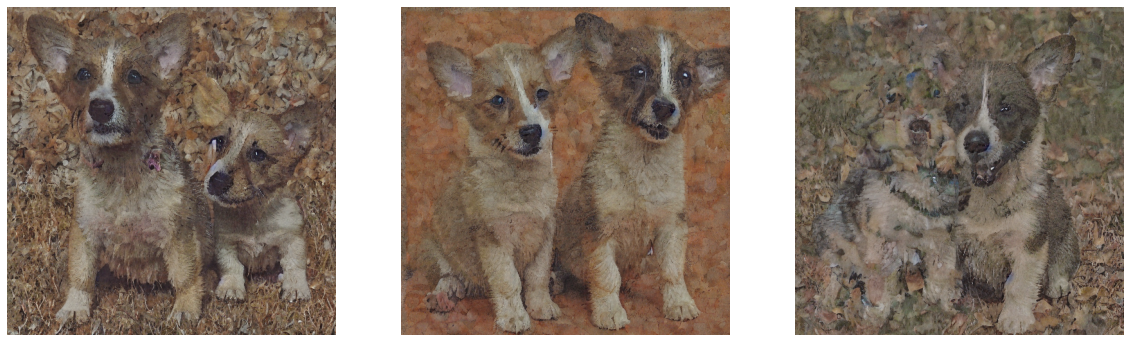

In [29]:
plot_images(inference_images)

In [ ]:
# to terminate the instance from Colab, or you can go into lambdalabs website to manually terminate.
# !sky down rh-a100